# Automation

In [1]:
# Set up matrix and mapper
def create_matrix(df, user, item, rating):
  import numpy as np
  from scipy.sparse import csr_matrix

  U = df[user].nunique()  # Number of users for the matrix
  I = df[item].nunique()  # Number of items for the matrix

  # Map user and movie IDs to matrix indices
  user_mapper = dict(zip(np.unique(df[user]), list(range(U))))
  item_mapper = dict(zip(np.unique(df[item]), list(range(I))))

  # Map matrix indices back to IDs
  user_inv_mapper = dict(zip(list(range(U)), np.unique(df[user])))
  item_inv_mapper = dict(zip(list(range(I)), np.unique(df[item])))

  # Create a list of index values for the csr_matrix for users and movies
  user_index = [user_mapper[i] for i in df[user]]
  item_index = [item_mapper[i] for i in df[item]]

  # Build the final matrix which will look like: (movieId, userId) rating
  X = csr_matrix((df[rating], (item_index, user_index)), shape=(I, U))

  return X, user_mapper, item_mapper, user_inv_mapper, item_inv_mapper

def recommend(itemId, X, item_mapper, item_inv_mapper, k, metric='cosine', messages=True):
    from sklearn.neighbors import NearestNeighbors
    import numpy as np

    rec_ids = []                # Make a list for the recommended item IDs we'll get later
    item = item_mapper[itemId]  # Get the index of the movie ID passed into the function
    item_vector = X[item]       # Get the vector of user ratings for the movie ID passed into the function

    # Fit the clustering algorithm based on the user-item matrix X
    knn = NearestNeighbors(n_neighbors=k+1, algorithm="brute", metric=metric).fit(X)

    # Call the trained knn cluster model to return the nearest neighbors of the item_vector passed in
    rec = knn.kneighbors(item_vector.reshape(1,-1), return_distance=True)
    rec_indeces = rec[1][0]     # Parse out the list of indeces of the recommended items
    rec_distances = rec[0][0]   # Parse out the recommendation strength calculated as the distance from the cluster center
    rec_distances = 1 - np.delete(rec_distances, 0) # Drop the first number in the list because it is the distance of itemId from itself

    # We need to replace the recommended item indeces with their original item IDs
    for i in range(1, knn.n_neighbors): # n_neighbors is the number of neighbors to return
        rec_ids.append(item_inv_mapper[rec_indeces[i]])
        
    # It may help to see what this is. The distance list is first and the recommended item indeces are second
    if messages:
        print(f'List of recommended item indeces:\n{rec_indeces}\n')
        print(f'List of recommended item IDs:\n{rec_ids}\n')
        print(f'List of recommended item similarity to selected item:\n{rec_distances}\n')

    # Return two lists: the original item IDs of the recommendations and their similarity scores
    return rec_ids, rec_distances

def hybrid_recommend(show_id, X, item_mapper, item_inv_mapper, content_sim_df, k=5, alpha=0.7):
    """
    show_id: the target show
    X: collaborative matrix (item x user)
    content_sim_df: cosine similarity from TF-IDF
    alpha: weight between 0 (only content) and 1 (only collaborative)
    """
    # --- Collaborative Filtering ---
    try:
        cf_ids, cf_scores = recommend(show_id, X, item_mapper, item_inv_mapper, k=k+10)
    except:
        cf_ids, cf_scores = [], []

    cf_dict = dict(zip(cf_ids, cf_scores))

    # --- Content-Based Filtering ---
    try:
        cb_scores = content_sim_df[show_id].drop(labels=[show_id])  # Drop self
        cb_ids = cb_scores.sort_values(ascending=False).head(k+10).index.tolist()
        cb_scores = cb_scores.loc[cb_ids].values.tolist()
    except:
        cb_ids, cb_scores = [], []

    cb_dict = dict(zip(cb_ids, cb_scores))

    # --- Combine Scores ---
    combined_scores = {}
    all_ids = set(cf_ids + cb_ids)

    for sid in all_ids:
        cf_score = cf_dict.get(sid, 0)
        cb_score = cb_dict.get(sid, 0)
        combined_scores[sid] = alpha * cf_score + (1 - alpha) * cb_score

    # Sort by combined score
    sorted_scores = sorted(combined_scores.items(), key=lambda x: x[1], reverse=True)
    top_ids = [sid for sid, _ in sorted_scores[:k]]
    top_scores = [score for _, score in sorted_scores[:k]]
    return top_ids, top_scores


# Data Understanding

,user_id,show_id,rating
0,1,s8381,4
1,1,s3466,5
2,1,s3181,4
3,1,s294,3
4,1,s7739,5


,show_id,type,title,director,cast,country,release_year,rating,duration,description,...,Language TV Shows,Musicals,Nature TV,Reality TV,Spirituality,TV Action,TV Comedies,TV Dramas,Talk Shows TV Comedies,Thrillers
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,"Michael Hilow, Ana Hoffman, Dick Johnson, Kirs...",United States,2020,PG-13,90 min,As her father nears the end of his life filmma...,...,0,0,0,0,0,0,0,0,0,0
1,s2,TV Show,Blood & Water,NaN,Ama Qamata Khosi Ngema Gail Mabalane Thabang M...,South Africa,2021,TV-MA,2 Seasons,After crossing paths at a party a Cape Town te...,...,0,0,0,0,0,0,0,1,0,0
2,s3,TV Show,Ganglands,Julien Leclercq,Sami Bouajila Tracy Gotoas Samuel Jouy Nabiha ...,NaN,2021,TV-MA,1 Season,To protect his family from a powerful drug lor...,...,0,0,0,0,0,1,0,0,0,0
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,2021,TV-MA,1 Season,Feuds flirtations and toilet talk go down amon...,...,0,0,0,1,0,0,0,0,0,0
4,s5,TV Show,Kota Factory,NaN,Mayur More Jitendra Kumar Ranjan Raj Alam Khan...,India,2021,TV-MA,2 Seasons,In a city of coaching centers known to train I...,...,0,0,0,0,0,0,1,0,0,0


,user_id,name,phone,email,age,gender,Netflix,Amazon Prime,Disney+,Paramount+,Max,Hulu,Apple TV+,Peacock,city,state,zip
0,1,Stephen Peters,890.309.2971,esmith@hotmail.com,18,Male,0,0,0,1,0,1,1,0,New John,CT,53771
1,2,Vicki Thomas,399.837.0996,callahanmichael@gmail.com,51,Female,0,0,1,0,0,0,1,1,Lake Robert,TN,71689
2,3,Jesse Bright,(268)691-6431,acline@shelton.biz,30,Female,0,0,0,1,0,0,0,1,East Tinaside,ME,40660
3,4,Mark Hernandez,+1-473-252-5923x513,deborah33@yahoo.com,22,Male,0,1,1,0,1,0,1,1,Bowenchester,VA,17039
4,5,Cynthia Armstrong,001-015-883-2813x8196,amycastillo@larsen.com,40,Female,1,0,1,1,1,0,1,0,North Thomasland,GA,77006


(2147, 3) (8508, 42) (200, 17)
Number of ratings: 2147
Number of unique movieId's: 1809
Number of unique users: 200
Average ratings per user: 10.73
Average ratings per movie: 1.19
Counts of how many times each movie was rated count
1    1514
2     258
3      31
4       6
Name: count, dtype: int64
Spread of the count shows were rated: 
Min:		 1
Quartile 1:	 1.0
Median:		 1.0
Quartile 3:	 1.0
Max:		 4
Duplicate ratings: 0
Nulls of each column in user: user_id         0
name            0
phone           0
email           0
age             0
gender          0
Netflix         0
Amazon Prime    0
Disney+         0
Paramount+      0
Max             0
Hulu            0
Apple TV+       0
Peacock         0
city            0
state           0
zip             0
dtype: int64


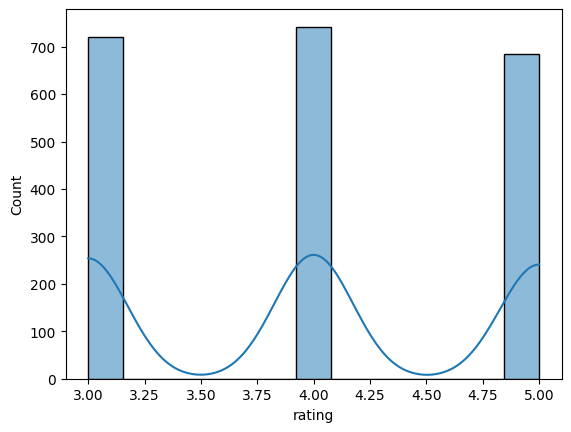

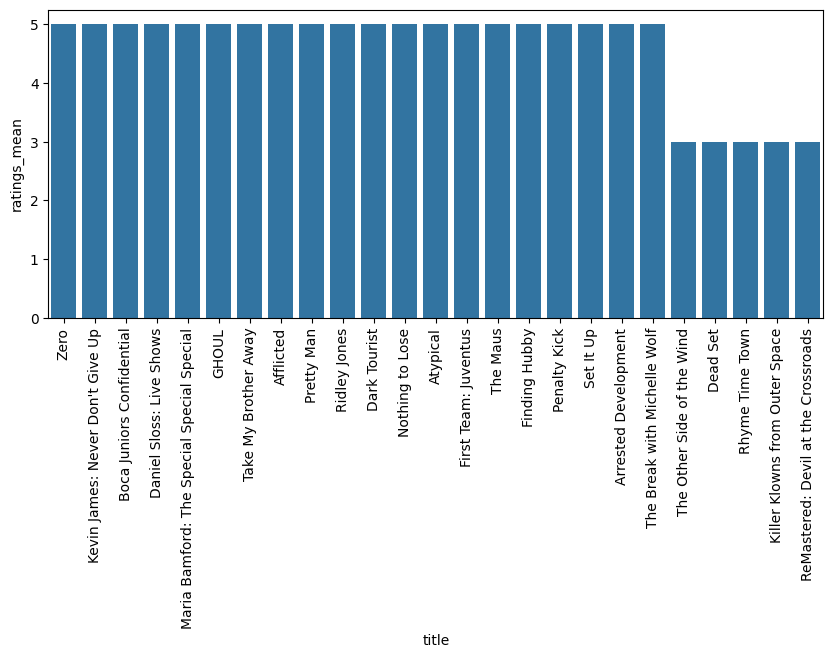

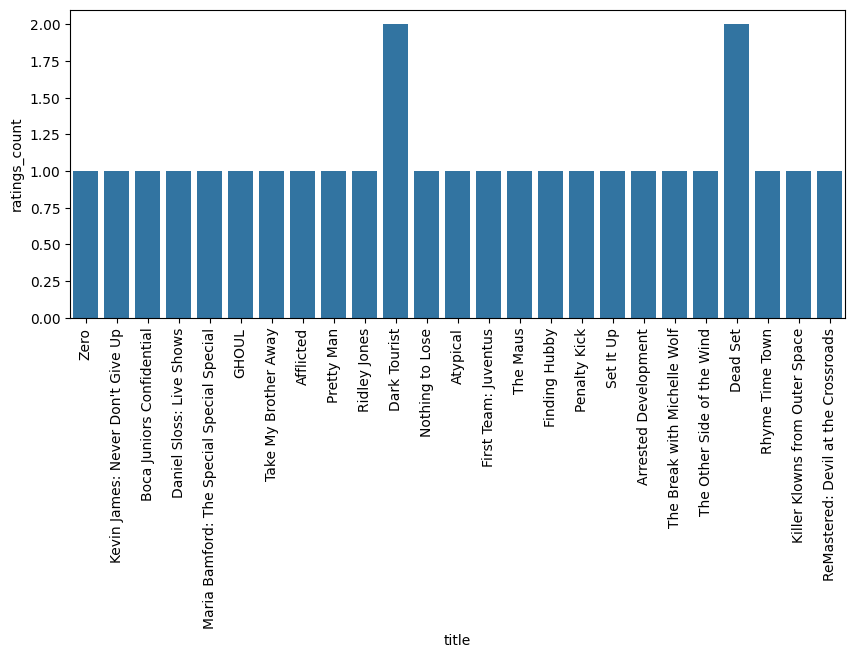

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sqlalchemy import create_engine

df_ratings = pd.read_csv('movies_ratings.csv')
df_titles = pd.read_csv('movies_titles.csv')
df_users = pd.read_csv('movies_users.csv')

display(df_ratings.head())
display(df_titles.head())
display(df_users.head())
print(df_ratings.shape, df_titles.shape, df_users.shape)

sns.histplot(data=df_ratings, x='rating', kde=True)

n_ratings = len(df_ratings)
n_movies = len(df_ratings['show_id'].unique())
n_users = len(df_ratings['user_id'].unique())

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique movieId's: {n_movies}")
print(f"Number of unique users: {n_users}")
print(f"Average ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average ratings per movie: {round(n_ratings/n_movies, 2)}")
print(f"Counts of how many times each movie was rated {df_ratings['show_id'].value_counts().value_counts()}")

print('Spread of the count shows were rated: ')
print('Min:\t\t', df_ratings['show_id'].value_counts().min())
print('Quartile 1:\t', df_ratings['show_id'].value_counts().quantile(.25))
print('Median:\t\t', df_ratings['show_id'].value_counts().quantile(.5))
print('Quartile 3:\t', df_ratings['show_id'].value_counts().quantile(.75))
print('Max:\t\t', df_ratings['show_id'].value_counts().max())

print(f"Duplicate ratings: {df_ratings.duplicated(subset=['user_id', 'show_id']).sum()}")
print(f'Nulls of each column in user: {df_users.isna().sum()}')

# Visualize the average rating for each movie

# Group the rows into individual titles and calculate the mean rating for each row
movie_stats = df_ratings.groupby(by=['show_id'])[['rating']].agg(['count', 'mean'])
movie_stats.columns = ['ratings_count', 'ratings_mean'] # Rename the columns to simplify the index

# Join with df_titles to get the titles
movie_stats = movie_stats.reset_index().merge(
    df_titles[['show_id', 'title']], 
    on='show_id', 
    how='left'
)

# Sort the ratings
movie_stats = movie_stats.sort_values(by=['ratings_mean'], ascending=False)

# Create a smaller dataset of the top n and bottom n rated movies
df_reduced = pd.concat([movie_stats.head(20), movie_stats.tail(5)])

plt.figure(figsize=(10,4)) # Set the size of the figure
sns.barplot(data=df_reduced, x='title', y='ratings_mean')
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(10,4)) # Set the size of the figure
sns.barplot(data=df_reduced, x='title', y='ratings_count')
plt.xticks(rotation=90)
plt.show()

# Data Preparation

In [3]:
df_titles.drop('director', axis=1, inplace=True)
df_titles.dropna(inplace=True)
# Make sure that the ratings dataframe includes only the shows that weren't deleted from dropping empty rows
common_ids = set(df_titles['show_id']).intersection(set(df_ratings['show_id']))
df_titles = df_titles[df_titles['show_id'].isin(common_ids)]
df_ratings = df_ratings[df_ratings['show_id'].isin(common_ids)]

# Prep user dataframe for use
df_users.drop(columns=['city','state','zip','email','name','phone'])

# To help with cold start problem, here's beysian math transformation
# Step 1: Compute global average rating (C)
C = df_ratings['rating'].mean()

# Step 2: Compute number of ratings and average rating per movie
movie_stats = df_ratings.groupby('show_id').agg(
    v=('rating', 'count'),  # number of ratings
    R=('rating', 'mean')    # average rating
).reset_index()

# Step 3: Choose a minimum number of ratings threshold (m)
m = 1  # tweak this based on your dataset

# Step 4: Compute Bayesian average
movie_stats['bayesian_rating'] = (
    (movie_stats['v'] / (movie_stats['v'] + m)) * movie_stats['R']
    + (m / (movie_stats['v'] + m)) * C
)

# Step 5: Merge back and overwrite the 'rating' column
df_ratings = df_ratings.merge(
    movie_stats[['show_id', 'bayesian_rating']],
    on='show_id',
    how='left'
)

df_ratings['rating'] = df_ratings['bayesian_rating']
df_ratings.drop(columns=['bayesian_rating'], inplace=True)

# Modeling and Evaluation

### Collaborative

In [4]:
X, user_mapper, item_mapper, user_inv_mapper, item_inv_mapper = create_matrix(df_ratings, 'user_id', 'show_id', 'rating')
print(X)
print(user_mapper)
print(user_inv_mapper)
print(item_mapper)
print(item_inv_mapper)
sparsity = round(1.0 - len(df_ratings) / float(len(user_mapper) * len(item_mapper)), 3)
print('The sparsity level of this matrix is {}%'.format(sparsity * 100))
# Set index for making sure things work
df_titles = df_titles.set_index('show_id')

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1882 stored elements and shape (1592, 200)>
  Coords	Values
  (0, 179)	4.492561105207226
  (1, 103)	3.4925611052072263
  (2, 144)	4.492561105207226
  (3, 158)	3.4925611052072263
  (4, 50)	3.3283740701381506
  (4, 124)	3.3283740701381506
  (5, 171)	4.492561105207226
  (6, 19)	4.496280552603613
  (6, 78)	4.496280552603613
  (6, 138)	4.496280552603613
  (7, 4)	4.328374070138151
  (7, 160)	4.328374070138151
  (8, 176)	4.492561105207226
  (9, 121)	3.4925611052072263
  (10, 112)	3.4925611052072263
  (11, 142)	3.9950407368048175
  (11, 193)	3.9950407368048175
  (12, 52)	3.9925611052072263
  (13, 64)	3.4925611052072263
  (14, 144)	4.492561105207226
  (15, 115)	3.9925611052072263
  (16, 52)	4.492561105207226
  (17, 101)	4.492561105207226
  (18, 87)	4.492561105207226
  (19, 100)	4.328374070138151
  :	:
  (1568, 106)	4.492561105207226
  (1569, 18)	3.9925611052072263
  (1570, 172)	4.492561105207226
  (1571, 52)	4.492561105207226
  (1572

### Content

In [5]:
# Modeling
# May need to add our own dictionary
# Create a TfidfVectorizer and Remove stopwords
tfidf = TfidfVectorizer(stop_words='english')

# Fit and transform the data to a tfidf matrix
df_titles['combined'] = df_titles['title'] + ' ' + df_titles['description']
tfidf_matrix = tfidf.fit_transform(df_titles['combined'])
        
# Print the shape of the tfidf_matrix
print(tfidf_matrix.shape)

# Compute cosine similarity (faster for sparse TF-IDF)
content_similarity = linear_kernel(tfidf_matrix, tfidf_matrix)

# Create a DataFrame with show_id indices
content_sim_df = pd.DataFrame(content_similarity, index=df_titles.index, columns=df_titles.index)

(1592, 8587)


# Deployment

##### To get a "great" for our grade. I took the content and collaborative filtering methods and combined them to create a table of top 5 recommendations for each movie

In [6]:
columns = ['If you like', 'Recommendation 1', 'Recommendation 2', 'Recommendation 3', 'Recommendation 4', 'Recommendation 5']
df_recommendations = pd.DataFrame(columns=columns, index=item_mapper.keys())

for show_id in df_recommendations.index:
    try:
        # Get hybrid recommendations
        rec_ids, _ = hybrid_recommend(
            show_id=show_id,
            X=X,
            item_mapper=item_mapper,
            item_inv_mapper=item_inv_mapper,
            content_sim_df=content_sim_df,
            k=5,
            alpha=0.7
        )

        # Fill in the row
        df_recommendations.at[show_id, 'If you like'] = df_titles.loc[show_id]['title']
        for i, rec_id in enumerate(rec_ids):
            df_recommendations.at[show_id, f'Recommendation {i+1}'] = df_titles.loc[rec_id]['title']

    except Exception as e:
        continue  # Skip this show if anything breaks

# Write to SQLite database
engine = create_engine("sqlite:///recommender.db")
df_recommendations.to_sql('top5_showids', con=engine, if_exists='replace', index=False)

List of recommended item indeces:
[   0  121 1016  460 1111 1542  182 1061 1058 1066 1065 1064 1063 1062
 1068 1060]

List of recommended item IDs:
['s1659', 's5883', 's3256', 's6358', 's8654', 's1929', 's6112', 's6105', 's6150', 's6138', 's6128', 's6118', 's6116', 's6158', 's6111']

List of recommended item similarity to selected item:
[1.         1.         1.         1.         0.70710678 0.70710678
 0.         0.         0.         0.         0.         0.
 0.         0.         0.        ]

List of recommended item indeces:
[1321    1 1295 1194  960  521  700 1040  866  885 1461 1063 1066 1065
 1058 1064]

List of recommended item IDs:
['s1005', 's7434', 's6839', 's5592', 's3570', 's4396', 's5992', 's5111', 's5238', 's8276', 's6118', 's6150', 's6138', 's6105', 's6128']

List of recommended item similarity to selected item:
[1.         1.         1.         1.         1.         1.
 1.         0.70710678 0.70710678 0.57735027 0.         0.
 0.         0.         0.        ]

List o

1592